In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Teorema do Limite central
Quanto maior o número de amostras geradas a partir de uma distribuição, a distribuição das médias dessa amostras se aproxima de uma normal. 

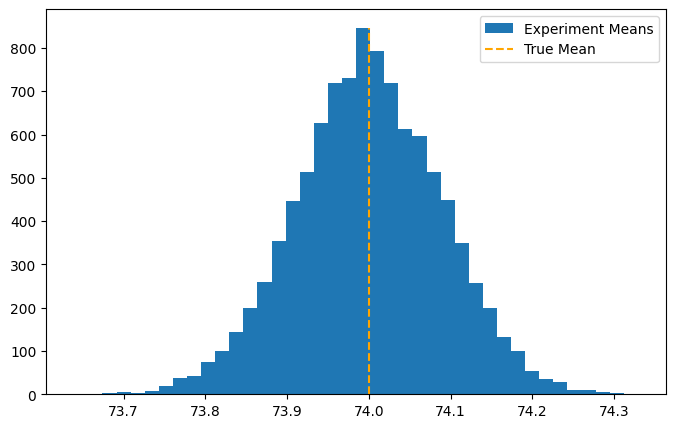

In [27]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(n=500): 
    return np.random.normal(true_mean,true_std, n)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

# Standard Error of mean
É uma medida de confiança para uma amostra de uma distribuição. Ela é o desvio padrão da amostra.

In [26]:
def se(sampling):
    return sampling.std()/np.sqrt(len(sampling))

In [28]:
se(run_experiment(10))

0.447874905839476

In [29]:
se(run_experiment(100))

0.19271155704675447

# Intervalo de confiança
A partir da média de uma amostra, nós podemos calcular um intervalo de confiança que vai ter uma grande chance de conter a média real. Sabendo que as médias das amostras se aproximam de uma distribuição normal e que 95% da massa de uma distribuição normal esta entre 2 desvios padrões, nós podemos multiplicar SE da amostra por dois e subtrair(e adicionar) esse valor pela média da amostra. Assim teremos um intervalo com 95% de chance de conter a  média real.

In [34]:
sampling = run_experiment(1000)
def ci(sampling):
    mean = sampling.mean()
    sampling_se = se(sampling)
    return (mean - 2*sampling_se, mean  + 2*sampling_se)
ci(sampling), true_mean

((73.86830524916681, 74.1254767934295), 74)

In [20]:
np.random.exponential(1.0, size=10)

array([0.72365634, 0.09770855, 0.04832344, 0.18569541, 1.13570571,
       0.17556301, 1.62209392, 3.45407686, 1.68081863, 1.3506459 ])

In [16]:
data = pd.read_csv('data/course/online_classroom.csv')
data.head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000


In [17]:
data.shape

(323, 10)

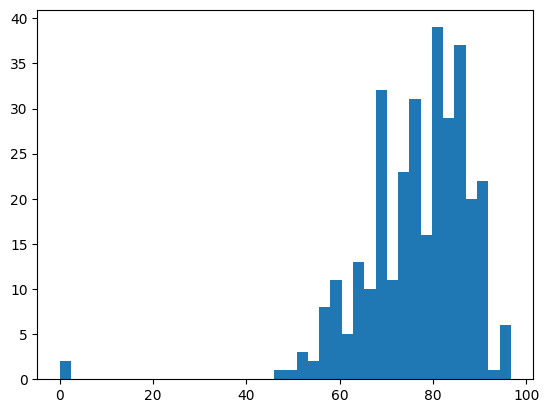

In [15]:
plt.hist(data.falsexam, bins=40);

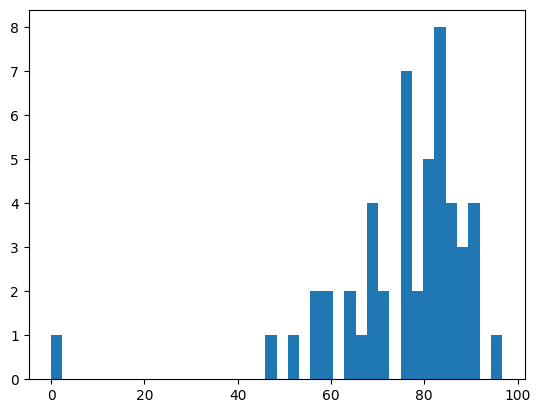

In [19]:
plt.hist(data.sample(50).falsexam, bins=40);

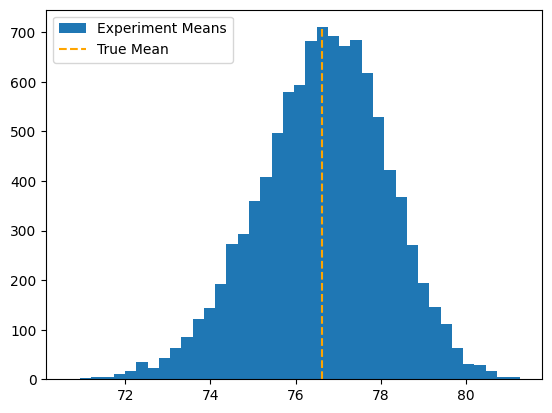

In [18]:
freq, bins, img = plt.hist([data.sample(50).falsexam.mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(data.falsexam.mean(), ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

In [24]:
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]
online.mean(), face_to_face.mean()

(73.63526308510637, 78.54748458333333)

In [35]:
ci(online), ci(face_to_face)

((70.56094429049804, 76.7095818797147), (76.80278229206951, 80.29218687459715))

In [39]:
# A diferença entre duas distribuições normais é um distribuição normal
# Com isso, também podemos calcular o intervalo de confiança para a diferença das médias
diff_mean = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
diff_ci = (diff_mean - 2*diff_se, diff_mean + 2*diff_se)
diff_mean, diff_se, diff_ci

(-4.912221498226955,
 1.7674432194573626,
 (-8.44710793714168, -1.3773350593122302))

In [40]:
z = diff_mean/diff_se
z

-2.7792810791031224

# Regressão linear
O cálculo do ATE pode ser feito utilizando uma regressão linear, o ATE vai ser o coeficiente da variável que representa o tratamento. Em experimentos randomizados, esse valor pode ser a partir de em uma regressão considerando a apenas o tratamento como uma variável dependente.

In [6]:
data = pd.read_csv("data/course/online_classroom.csv").query("format_blended==0")
data = data.dropna()
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.7791,1.133,69.527,0.000,76.542,81.016
format_ol,-4.3957,1.761,-2.497,0.014,-7.872,-0.920


In [7]:
# Em experimentos randomizados, ATE = Cov(Y, T)/var(T)
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.395717929292931

In [12]:
# Em experimentos não randomizados, ATE = Cov(Y, T_resid)/var(T_resid), 
# onde T_resid é o residuo da regressão das covariates sobre T, 
# sendo assim estamos avaliando o efeito do tratamento desconsiderando 
# os efeitos das outras variáveis

covariates = data.drop(columns=['format_ol', 'format_blended', 'falsexam'])
covariates_str = ' + '.join(covariates)
result = smf.ols(f'format_ol ~ {covariates_str}', data=data).fit()
t_resid = result.resid

kapa = data['falsexam'].cov(t_resid) / t_resid.var()
kapa

-4.2414526737047975

In [14]:
## Esse cálculo tem o mesmo efeito que fazer a regressão da covariates 
# junto com tratamento para prever o outcome
covariates = data.drop(columns=['format_blended', 'falsexam'])
covariates_str = ' + '.join(covariates)
result = smf.ols(f'falsexam ~ {covariates_str}', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,65.0397,2.546,25.544,0.000,60.012,70.068
gender,4.5745,1.790,2.556,0.012,1.041,8.108
asian,11.2076,2.744,4.085,0.000,5.790,16.625
black,8.5765,3.842,2.232,0.027,0.990,16.163
hawaiian,20.9018,9.487,2.203,0.029,2.169,39.635
hispanic,13.5779,5.774,2.352,0.020,2.176,24.980
unknown,2.34e-15,1.77e-15,1.326,0.187,-1.15e-15,5.83e-15
white,10.7759,2.448,4.402,0.000,5.942,15.610
format_ol,-4.2415,1.774,-2.390,0.018,-7.745,-0.738
